In [1]:
from sklearn.datasets import load_boston
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

/Users/sergmiller/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.style.use('ggplot')
%matplotlib inline

In [3]:
data = load_boston()

In [4]:
X = data['data']
y = data['target']

In [14]:
class DecisionTree(BaseEstimator):
    '''
    Simple decision tree regressor with MSE rule and random best split by one feature,
    X and y -Features and Targets, must have numpy.ndarray class
    n_partitions - Number of partitions in each split, n_partitions = number of values if None 
    err_f - H(R) - Inhomogeneity function
    '''
    class Node(object):
        def __init__(self, X, y, err_f, n_partitions, max_depth, n_features):
            self.isLeaf = True
            self.err_f = err_f
            self.max_depth = max_depth
            self.n_partitions = n_partitions
            self.n_features = n_features
            if self.n_partitions:
                self.n_partitions = max(2, self.n_partitions)
                self.quants = np.arange(self.n_partitions)/(self.n_partitions - 1)
            self.X = X
            self.y = y
            self.split()
            
        def bin_err(self, B):
            return self.err_f(B, np.ones_like(B)*np.mean(B))
        
        def total_err(self,err_L,err_R,L,R,Q):
            return L/Q*err_L + R/Q*err_R
            
        def partition_err(self, bins):
            Q = len(self.y)
            R = np.sum(bins)
            L = Q - R
            R_bin = self.y[bins > 0]
            L_bin = self.y[bins < 1]
            err_L = self.bin_err(L_bin)
            err_R = self.bin_err(R_bin)
            return self.total_err(err_L,err_R,L,R,Q)
                
        def split(self):
            #bound conditions for exit
            if self.max_depth == 0 or len(self.X) <= 1:
                self.predict = np.mean(self.y)
                return
            
            self.split_err = np.inf
            fts = np.arange(len(self.X[0]))
            np.random.shuffle(fts)
            if self.n_features is not None:
                fts = fts[:self.n_features]
            for ft in fts:
                X_feature_slice = self.X[:,ft]
                
                good_slice = np.sort(np.unique(X_feature_slice))
                good_slice = good_slice[good_slice < np.max(good_slice)]
                
                if len(good_slice) >= 1:

                    if  self.n_partitions:
                        partitions = good_slice[np.array(self.quants * (len(good_slice)-1),dtype=int)]
                    else:
                        partitions = good_slice

                    for bound in partitions:
                        bins =  (X_feature_slice > bound)
                        error = self.partition_err(bins)
                        
                        # update best split
                        if error < self.split_err:
                            self.split_err = error
                            self.split_bins = bins
                            self.split_feature = ft
                            self.split_bound = bound
            
            #suitable partitions aren't founded
            if self.split_err == np.inf:
                self.predict = np.mean(self.y)
                return
            
            self.isLeaf = False
            
            #depth for childs
            md = self.max_depth
            if md:
                md -= 1
                
            self.Left = DecisionTree.Node(self.X[self.split_bins < 1], self.y[self.split_bins < 1], 
                                          self.err_f, self.n_partitions, md, self.n_features)
            
            self.Right = DecisionTree.Node(self.X[self.split_bins > 0], self.y[self.split_bins > 0], 
                                           self.err_f, self.n_partitions, md, self.n_features) 
            
    def __init__(self, err_f = mean_squared_error, n_partitions=None,max_depth=None,n_features=None):
        self.err_f = err_f
        self.max_depth = max_depth
        self.n_partitions = n_partitions
        self.n_features = n_features
        
    def fit(self, X, y):
        self.root = self.Node(X,y,self.err_f, self.n_partitions, self.max_depth, self.n_features)
    
    def find(self,x):
        cur = self.root
        while not cur.isLeaf:
            if x[cur.split_feature] > cur.split_bound:
                cur = cur.Right
            else:
                cur = cur.Left
        return cur.predict
        
    def predict(self, X):
        return np.array([self.find(x) for x in X])

Сначала проведем кросс-валидацию при различном числе рассматриваемых разбиений

In [9]:
def benchmark(clfr,params,label,hmax=5):
    scores = []
    for h in range(1,hmax):
        params['max_depth'] = h
        clf = clfr(**params)
        scores.append(np.mean(cross_validation.cross_val_score(clf,X,y,n_jobs=4,scoring=make_scorer(mean_squared_error),cv=4)))
    plt.plot(np.arange(1,hmax),scores,label=label)

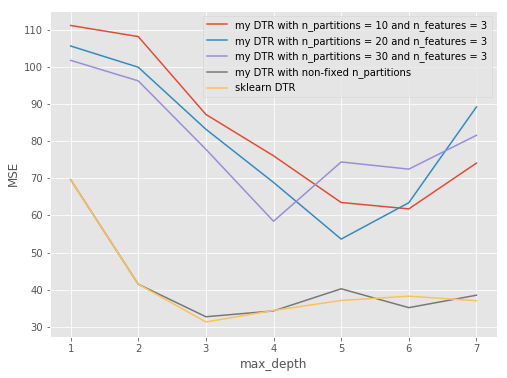

CPU times: user 2.23 s, sys: 1.06 s, total: 3.29 s
Wall time: 59.8 s


In [15]:
%%time
h = 8
ft = 3
plt.figure(figsize=(8,6))
for p in np.arange(10,40,10):
    benchmark(DecisionTree, {'n_partitions':p,'n_features':ft},
              'my DTR with n_partitions = ' + str(p) + ' and n_features = ' + str(ft), h)
benchmark(DecisionTree, {},'my DTR with non-fixed n_partitions', h)
benchmark(DecisionTreeRegressor, {'random_state':1},'sklearn DTR',h)
plt.legend(loc='best')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.show()

Сделаем так, как просят в задании. В тестировании будем использовать дерево с поиском по всем разбиениям.

In [53]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.25, random_state=1)

In [56]:
def test_mse_score(clfr,params,label,X_train,X_test,y_train,y_test,hmax=5):
    scores = []
    for h in range(1,hmax):
        params['max_depth'] = h
        clf = clfr(**params)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        scores.append(mean_squared_error(y_pred,y_test))
    plt.plot(np.arange(1,hmax),scores,label=label)

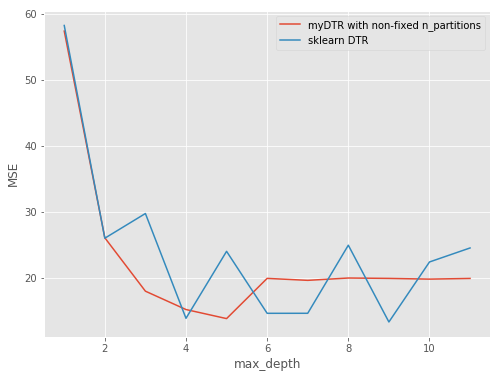

CPU times: user 34.1 s, sys: 261 ms, total: 34.3 s
Wall time: 34.8 s


In [75]:
%%time
h = 12
plt.figure(figsize=(8,6))
test_mse_score(DecisionTree,{},'myDTR with non-fixed n_partitions',X_train,X_test,y_train,y_test,h)
test_mse_score(DecisionTreeRegressor,{'random_state':1},'sklearn DTR',X_train,X_test,y_train,y_test,h)
plt.legend(loc='best')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.show()

Как видно, получилась неплохая реализация.